In [10]:
import os
os.chdir("../../")

os.environ['LATEXIFY']=str(1)
os.environ['FIG_DIR']='figures/motorhelmet'
from probml_utils import savefig, latexify
latexify(width_scale_factor=2.4, fig_height=2)

In [11]:
from models.gaussian_mlp import gmlp
from models.mlp import mlp
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot,errors

In [12]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

from probml_utils.blackjax_utils import inference_loop
import blackjax
import flax
from flax import linen as nn
from flax.core import unfreeze
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import sin_data
import tensorflow_probability.substrates.jax as tfp
from jax import tree_map
from jax.flatten_util import ravel_pytree
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import regdata as rd


In [13]:
n_points = 300
x_train, y_train = rd.MotorcycleHelmet(return_test=False).get_data()
x_train = jnp.array(x_train)
y_train = jnp.array(y_train).reshape(-1,1)
x_linspace_test = jnp.linspace(-4, 4, n_points).reshape(-1, 1)

In [9]:

batch_size = 32
epochs = 200
learning_rate = 0.006

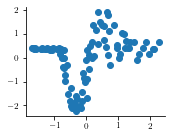

In [10]:
plt.plot(x_train,y_train,'o')
x_train=jnp.array(x_train)
y_train=jnp.array(y_train)
sns.despine()

## MLP

In [11]:
mlp_model = mlp([16,16, 1], [nn.relu] * 2, [0] * 2)
mlp_params = mlp_model.init(jax.random.PRNGKey(0), x_train, True)

In [12]:
mlp_params, mlp_loss = fit(
    mlp_model, mlp_params, x_train, y_train, False, learning_rate=learning_rate, epochs=epochs,batch_size=batch_size,rng=jax.random.PRNGKey(1)
)

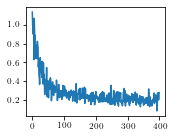

In [13]:
plt.plot(mlp_loss)

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/MLP.pdf to figures/motorhelmet/MLP_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/MLP_latexified.pdf
Figure size: [2.5 2. ]


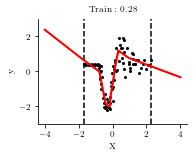

In [15]:
n_points = 300
y_hat = mlp_model.apply(mlp_params, x_linspace_test, True).reshape(-1)
y_hat_train = mlp_model.apply(mlp_params, x_train, True)
ax = plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,y_hat,
jnp.zeros(y_hat.shape[0]),y_min=-3,y_max=3,title=f'Train : {mlp_loss[-1]:.2f}')

sns.despine()
savefig('MLP.pdf')

## Gaussian MLP

In [16]:
gmlp_model = gmlp(features=[16,16], activations=[nn.relu] * 2, dropout_rate=[0.01] * 2)

In [17]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), x_train, True)

In [18]:
gmlp_params, loss = fit(
    gmlp_model,
    gmlp_params,
    x_train,
    y_train,
    deterministic=False,
    learning_rate=learning_rate,
    epochs=epochs,batch_size=batch_size
)

In [19]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_linspace_test, True)
gmlp_mean_train, gmlp_sigma_train = gmlp_model.apply(gmlp_params, x_train, True)
gmlp_train_loss = gmlp_model.loss_fn(gmlp_params, x_train,y_train, True, jax.random.PRNGKey(0))


 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/GMLP.pdf to figures/motorhelmet/GMLP_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/GMLP_latexified.pdf
Figure size: [2.5 2. ]


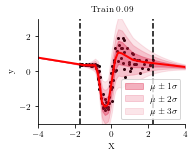

In [20]:
ax = plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,gmlp_mean,gmlp_sigma,y_min=-3,y_max=3,title=f'Train {gmlp_train_loss:.2f}')
ax.legend()
ax.set_xlim(-4,4)
savefig('GMLP.pdf')

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/Calibration_GMLP.pdf to figures/motorhelmet/Calibration_GMLP_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Calibration_GMLP_latexified.pdf
Figure size: [2.5 2. ]


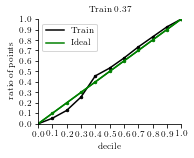

In [21]:
fig, ax = plt.subplots(1)
_, df_train = plot.calibration_regression(
    gmlp_mean_train, gmlp_sigma_train, y_train, "Train", "black", ax
)
ax.set_title(f"Train {errors.ace(df_train):.2f}")
k = jnp.arange(0, 1.1, 0.1)
ax.plot(k,k,label='Ideal',color='Green')
ax.legend()
savefig('Calibration_GMLP.pdf')

## Bootstrap

In [22]:
params_list = []
losses_list = []
n_models = 5
keys = jax.random.split(jax.random.PRNGKey(0),n_models)
for i in range(n_models):
    ids = jax.random.choice(keys[i], jnp.array(range(len(x_train))), (x_train.shape))
    x, y = x_train[ids].reshape(-1,1), y_train[ids].reshape(-1,1)
    params = gmlp_model.init(jax.random.PRNGKey(i), x_train, deterministic = True)
    params, loss =  fit(gmlp_model, params, x, y, deterministic=False, learning_rate=learning_rate, epochs=epochs,batch_size=batch_size)
    params_list.append(params)
    losses_list.append(loss)

In [23]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_linspace_test)
bs_mean, bs_sigma = gmm_mean_var(means_list,sigmas_list)
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_train)
bs_mean_train, bs_sigma_train = gmm_mean_var(means_list,sigmas_list)

In [24]:
bs_mean, bs_sigma = bs_mean.reshape(n_points),bs_sigma.reshape(n_points)

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/Bootstrap.pdf to figures/motorhelmet/Bootstrap_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Bootstrap_latexified.pdf
Figure size: [2.5 2. ]


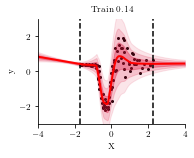

In [25]:
ax =plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,bs_mean,bs_sigma,y_min=-3,y_max=3,
title=f"Train {errors.loss(bs_mean_train,bs_sigma_train,y_train):.2f}")
ax.set_xlim(-4,4)
savefig('Bootstrap.pdf')

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/Calibration_Bootstrap.pdf to figures/motorhelmet/Calibration_Bootstrap_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Calibration_Bootstrap_latexified.pdf
Figure size: [2.5 2. ]


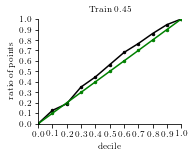

In [26]:
fig, ax = plt.subplots(1)
_, df_train = plot.calibration_regression(
    bs_mean_train, bs_sigma_train, y_train, "Train", "black", ax
)

ax.set_title(f"Train {errors.ace(df_train):.2f} ")
savefig('Calibration_Bootstrap.pdf')

## MC Dropout Gaussian MLP

In [27]:
n_stacks = 100
fn = lambda x, i: gmlp_model.apply(
    gmlp_params, x, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)}
)


In [28]:
y_stacks = jax.vmap(fn, in_axes=(None, 0))(x_linspace_test, jnp.arange(n_stacks))
mc_mean, mc_sigma = gmm_mean_var(y_stacks[0], y_stacks[1])
# y_stacks = jax.vmap(fn, in_axes=(None, 0))(x_test, jnp.arange(n_stacks))
# mc_mean_test, mc_sigma_test = gmm_mean_var(y_stacks[0], y_stacks[1])
y_stacks = jax.vmap(fn, in_axes=(None, 0))(x_train, jnp.arange(n_stacks))
mc_mean_train, mc_sigma_train = gmm_mean_var(y_stacks[0], y_stacks[1])

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/Calibration_MC.pdf to figures/motorhelmet/Calibration_MC_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Calibration_MC_latexified.pdf
Figure size: [2.5 2. ]


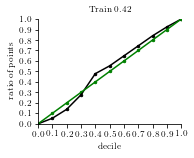

In [29]:
fig, ax = plt.subplots(1)
# _, df_test = plot.calibration_regression(
#     mc_mean_test, mc_sigma_test, y_test, "Test", "blue", ax
# )
_, df_train = plot.calibration_regression(
    mc_mean_train, mc_sigma_train, y_train, "Train", "black", ax
)
ax.set_title(f"Train {errors.ace(df_train):.2f} ")
savefig("Calibration_MC.pdf")

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/MC_Dropout.pdf to figures/motorhelmet/MC_Dropout_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/MC_Dropout_latexified.pdf
Figure size: [2.5 2. ]


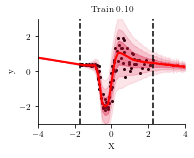

In [30]:
ax =plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,mc_mean,mc_sigma,y_min=-3,y_max=3,
title=f"Train {errors.loss(mc_mean_train,mc_sigma_train,y_train):.2f}")
ax.set_xlim(-4,4)
savefig('MC_Dropout.pdf')

## Deep Ensemble Gaussian MLP

In [31]:
params_list = []
losses_list = []
n_models = 5
for i in range(n_models):
    params = gmlp_model.init(jax.random.PRNGKey(4*i), x_train, deterministic=True)
    params, loss = fit(
        gmlp_model,
        params,
        x_train,
        y_train,
        deterministic=False,
        learning_rate=learning_rate,
        epochs=epochs,
        batch_size=batch_size
    )
    params_list.append(params)
    losses_list.append(loss)

In [32]:
means_list, sigmas_list = predict(n_models, gmlp_model, params_list, x_linspace_test)
de_mean, de_sigma = gmm_mean_var(means_list, sigmas_list)
means_list, sigmas_list = predict(n_models, gmlp_model, params_list, x_train)
de_mean_train, de_sigma_train = gmm_mean_var(means_list, sigmas_list)

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/Deep Ensemble.pdf to figures/motorhelmet/Deep Ensemble_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Deep Ensemble_latexified.pdf
Figure size: [2.5 2. ]


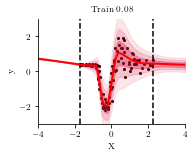

In [33]:
de_mean, de_sigma = de_mean.reshape(n_points), de_sigma.reshape(n_points)
ax=plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,de_mean,de_sigma,y_min=-3,y_max=3,
title=f"Train {errors.loss(de_mean_train,de_sigma_train,y_train):.2f}")
ax.set_xlim(-4,4)
savefig('Deep Ensemble.pdf')

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/Calibration_GMLP Deep Ensemble.pdf to figures/motorhelmet/Calibration_GMLP Deep Ensemble_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Calibration_GMLP Deep Ensemble_latexified.pdf
Figure size: [2.5 2. ]


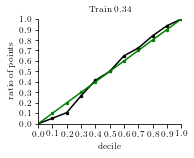

In [34]:
fig, ax = plt.subplots(1)
_, df_train = plot.calibration_regression(
    de_mean_train, de_sigma_train, y_train, "Train", "black", ax
)
ax.set_title(f"Train {errors.ace(df_train):.2f} ")

savefig('Calibration_GMLP Deep Ensemble.pdf')

In [35]:
key = jax.random.PRNGKey(42)
sigmaf = 1.0
len_scale = 1.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)

In [36]:
# %%capture
model_gp = GPy.models.GPRegression(x_train, y_train, kernel, normalizer=False)
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)

Optimization restart 1/5, f = 72.61568450927734
Optimization restart 2/5, f = 72.61568450927734
Optimization restart 3/5, f = 72.61569213867188
Optimization restart 4/5, f = 72.61569213867188
Optimization restart 5/5, f = 72.61569213867188


In [37]:
# %%capture
mu_gp, cov_gp = model_gp.predict(x_linspace_test)
mu_gp_train, cov_gp_train = model_gp.predict(x_train)
# mu_gp_test, cov_gp_test = model_gp.predict(x_test)
mu_gp = mu_gp.reshape(n_points)
sigma_gp = jnp.sqrt(cov_gp).reshape(n_points)

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/calibraion_gp.pdf to figures/motorhelmet/calibraion_gp_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/calibraion_gp_latexified.pdf
Figure size: [2.5 2. ]


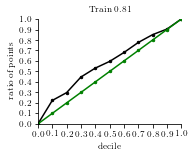

In [38]:
fig, ax = plt.subplots(1)
_, df_train = plot.calibration_regression(
    mu_gp_train.reshape(-1),
    jnp.sqrt(cov_gp_train).reshape(-1),
    y_train,
    "Train",
    'black',
    ax=ax,
)
ax.set_title(f"Train {errors.ace(df_train):.2f} ")
savefig('calibraion_gp.pdf')

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/GP.pdf to figures/motorhelmet/GP_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/GP_latexified.pdf
Figure size: [2.5 2. ]


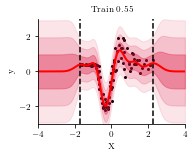

In [39]:
ax=plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,mu_gp,sigma_gp,y_min=-3,y_max=3
,title=f"Train {errors.loss( mu_gp_train.reshape(-1),    jnp.sqrt(cov_gp_train).reshape(-1),y_train):.2f}")
ax.set_xlim(-4,4)
savefig('GP.pdf')


In [40]:
def bnn_log_joint(params, X, y, model):
    mean, sigma = model.apply(params, X, deterministic=True)

    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 2.0).log_prob(flatten_params).sum()
    # log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_likelihood = tfd.Normal(mean, sigma).log_prob(y.reshape((-1,))).sum()
    log_joint = log_prior + log_likelihood
    return log_joint


bnn_log_joint_partial = partial(bnn_log_joint, X=x_train, y=y_train, model=gmlp_model)
bnn_log_joint_partial(params)

DeviceArray(-560.6869, dtype=float32)

In [41]:
num_warmup = 3000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)
num_samples = 1000
states, infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [42]:
def x_one_step(x):
    def one_step(carry, state):
        params_cur = state.position
        mean, sigma = gmlp_model.apply(params_cur, x, deterministic=True)
        return carry, (mean, sigma)
    return one_step

one_step_lin = x_one_step(x_linspace_test)
one_step_train = x_one_step(x_train)
_, (mean_stacks, sigma_stacks) = jax.lax.scan(one_step_lin, None, states)
_, (mean_stacks_train, sigma_stacks_train) = jax.lax.scan(one_step_train, None, states)

In [43]:
mean_mcmc, sigma_mcmc = gmm_mean_var(mean_stacks, sigma_stacks)
mean_mcmc_train, sigma_mcmc_train = gmm_mean_var(mean_stacks_train, sigma_stacks_train)

 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/MCMC_calibration.pdf to figures/motorhelmet/MCMC_calibration_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/MCMC_calibration_latexified.pdf
Figure size: [2.5 2. ]


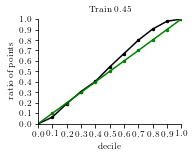

In [46]:
fig, ax = plt.subplots(1)
_, df_train = plot.calibration_regression(
    mean_mcmc_train, sigma_mcmc_train, y_train, "Train", "black", ax
)
ax.set_title(f"Train {errors.ace(df_train):.2f}")
savefig('MCMC_calibration.pdf')

saving image to figures/motorhelmet/MCMC_latexified.pdf
Figure size: [2.5 2. ]


 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning:renaming figures/motorhelmet/MCMC.pdf to figures/motorhelmet/MCMC_latexified.pdf because LATEXIFY is True


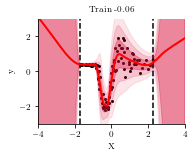

In [47]:
ax =plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,mean_mcmc,sigma_mcmc,y_min=-3,y_max=3,
title=f"Train {errors.loss(mean_mcmc_train, sigma_mcmc_train,y_train):.2f}")
ax.set_xlim(-4,4)
savefig('MCMC.pdf')

## VI

In [25]:
from utilities.vi_helper import vi_model,vi_predict
params =  [[16,16,1],[nn.relu]*2]

mlp_model_vi, vi_model, results = vi_model(params,x_train, y_train.flatten())

mean_vi = vi_predict(vi_model, results,mlp_model_vi,x_linspace_test).mean(axis = 0)
sigma_vi = vi_predict(vi_model, results,mlp_model_vi,x_linspace_test).std(axis = 0)
mean_vi_train = vi_predict(vi_model, results,mlp_model_vi,x_train).mean(axis = 0)
sigma_vi_train = vi_predict(vi_model, results,mlp_model_vi,x_train).std(axis = 0)

 /home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:70: UserWarning:renaming figures/motorhelmet/MLP_VI.pdf to figures/motorhelmet/MLP_VI_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/MLP_VI_latexified.pdf
Figure size: [2.5 2. ]


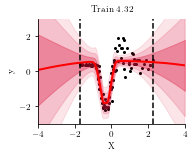

In [26]:
train_loss = errors.loss(mean_vi_train, sigma_vi_train, y_train)

ax =plot.plot_prediction_regression_without_test(x_train,y_train,x_linspace_test,mean_vi,sigma_vi,y_min=-3,y_max=3,
title=f"Train {errors.loss(mean_vi_train, sigma_vi_train,y_train):.2f}")
ax.set_xlim(-4,4)
savefig("MLP_VI.pdf")

 /home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:70: UserWarning:renaming figures/motorhelmet/Calibration_VI.pdf to figures/motorhelmet/Calibration_VI_latexified.pdf because LATEXIFY is True


saving image to figures/motorhelmet/Calibration_VI_latexified.pdf
Figure size: [2.5 2. ]


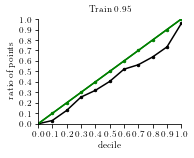

In [27]:
fig, ax = plt.subplots(1)
_, df_train = plot.calibration_regression(
    mean_vi_train, sigma_vi_train, y_train, "Train", "black", ax
)
ax.set_title(f"Train {errors.ace(df_train):.2f}")
k = jnp.arange(0, 1.1, 0.1)
ax.plot(k,k,label='Ideal',color='Green')
savefig('Calibration_VI.pdf')